# Titanic Survival Classification - ROC and Non-Decomposable  Objective Optimization

So the focus of this notebook is to learn what the ROC is and the AUCROC as a measure and how they are useful.  And then move on to implementing this as an approximate optimization metric for Keras based neural networks.

Note the primary references for this are - 

https://arxiv.org/abs/1608.04802

http://www.dataschool.io/roc-curves-and-auc-explained/

Also to make things significantly simpler I will only be dealing with binary classification for this notebook although in future I may use this optimization objective for more advanced problems.


In [1]:
##### First importing some relevant packages
import numpy as np
import pandas as pd

#Stop pandas from truncating output view
pd.options.display.max_columns = None

#Import Tensorflow
import tensorflow as tf

#Import Keras
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential, Model
from keras import regularizers
from keras.optimizers import Adam, SGD

#Import mathematical functions
from random import *
import math
import matplotlib
import matplotlib.pyplot as plt

#Get regular expression package
import re

#Import  Scikit learn framework
import sklearn as sk
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve

F:\anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import the functions built in previous parts
from Titanic_Import import *

full_set = pd.read_csv('D:/Datasets/Titanic/train.csv')
sub_set = pd.read_csv('D:/Datasets/Titanic/test.csv')

In [3]:
append_set = full_set
append_set = append_set.append([sub_set], ignore_index =True )
clean_set = Cleanse_Data_v3(append_set)
X_Train, Y_Train, X_CV, Y_CV, X_Test = dataset_splitter(clean_set, cv_size = 200)

So first thing I'm going to need is a couple of $\hat{Y}$ vectors to compute the ROC curve.  So lets build a simple classifier, also I will be using the sci-kit learn implementation to make things a bit simpler to start with.

In [4]:
scisvm = svm.SVC()
scisvm.fit(X_Train, Y_Train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [5]:
yhat_train = scisvm.predict(X_Train)
yhat_cv = scisvm.predict(X_CV)

print('Training Resuts')  
show_acc(Y_Train, yhat_train)
print('-------------------------------')
print('Cross Validation Resuts')  
show_acc(Y_CV, yhat_cv)

Training Resuts
Accuracy =  81.47612156295224
F1 Score =  0.7387755102040815

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        181.0          48.0
1  Pred False         80.0         382.0
-------------------------------
Cross Validation Resuts
Accuracy =  90.0
F1 Score =  0.8749999999999999

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         70.0           9.0
1  Pred False         11.0         110.0


So now we have our basic classifier, and a baseline of how the accuracy and F1 scores and confusion matrices look.  Lets have a look at the ROC as a metric then.

Note I modified the code from 

https://www.kaggle.com/nicapotato/catboost-aggregate-features/code

to use as a baseline for the syntax.

ROC Score :  0.790929341530785


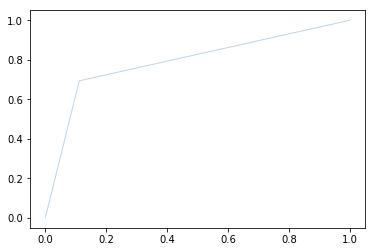

In [6]:
fpr, tpr, thresholds = roc_curve(Y_Train, yhat_train)
score = roc_auc_score(Y_Train, yhat_train)

plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC ' % (score))
print('ROC Score : ', score)

Okay this worked lets put it into a function and see how it did on Cross Validation.

ROC Score :  0.8942836393816785


0.8942836393816785

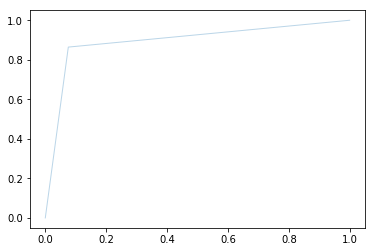

In [7]:
def show_ROC(Y, Y_hat) :
    fpr, tpr, thresholds = roc_curve(Y, Y_hat)
    score = roc_auc_score(Y, Y_hat)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC ' % (score))
    print('ROC Score : ', score)
    
    return score

show_ROC(Y_CV, yhat_cv)

So it seems like a reasonable way to visualize where data imbalances may cause errors in learning.

## Creating an optimization metric in Keras

So the next challenge will be to create a loss function to put into a keras metric to allow neural networks to optimize similar measures directly.

So to achieve this I'll implement the algorithms laid out in - Scalable Learning of Non-Decomposable Objectives. <br>
https://arxiv.org/abs/1608.04802

The basic idea is to use some mathematical trickery to create an inequality boundary for precision (or recall) at a fixed recall (or precision).  

This is achieved by splitting the loss function into positive and negative examples (eq. 1) and then applying another layer on top of the existing loss functions (eq. 5) and introducing another variable to optimize (eq. 6) - labelled as $\lambda$ in the above paper.

The resultant equation is then effectively an approximation of true/false positive rates which can be used to generate loss functions that optimize over approximations of the non-decomposable objectives.

Sources - 

Simple F-Score implementation as keras metric (used for syntax) <br>
https://gist.github.com/shadySource/fa287fc6448f84004284f5c086f59661/

Tensorflow implementation in Keras (again used for syntax) <br>
https://github.com/keras-team/keras/blob/master/keras/backend/tensorflow_backend.py

Optimizing Non-decomposable Measures with Deep Networks <br>
https://arxiv.org/abs/1802.00086

## Metric Implementation in Keras

As I've not used custom metrics in Keras before a logical place to start is to implement one of these metrics in keras directly to view the progress as it updates.

So to this end I will generate a new neural-network generation function (for experimentation) as below.

In [8]:
def NN_model_v2(input_shape, layers, act_reg, ker_reg):
    #Having dynamic input shape as I may do feature engineering later.
    X_input = Input(input_shape)
    
    X = Dense(layers[0], input_dim=input_shape, activation='relu')(X_input)
    #X = LeakyReLU()(X)
    #X = BatchNormalization()(X)

    #Our NN Layers
    for i in range(len(layers) - 1):
      X = Dense(layers[i + 1], activation='relu', activity_regularizer = act_reg, kernel_regularizer = ker_reg)(X)
      #X = LeakyReLU()(X)\
      #X = BatchNormalization()(X)

    
    X = Dense(1, activation='sigmoid')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Simple_model')

    return model

With this created I can now work on a function for a new metric, for simplicity I will generate the F1 score as this is a metric I'm somewhat familiar with.

In [9]:
def K_F1_score(y_true, y_pred):
    
    pred = tf.round(y_pred)
    y_pred_inv = tf.add(1.0, tf.multiply(-1.0, pred))
    y_true_inv = tf.add(1.0, tf.multiply(-1.0, y_true))
    
    tp = tf.reduce_sum(tf.multiply(y_true, y_pred))
    fp = tf.reduce_sum(tf.multiply(y_true_inv, y_pred))
    fn = tf.reduce_sum(tf.multiply(y_true, y_pred_inv))
    
    prec =  tf.divide(tp, tf.add(tf.add(tp, fp), 0.0000000001))
    rec = tf.divide(tp, tf.add(tf.add(tp, fn), 0.0000000001))
    
    score = tf.multiply(2.0, tf.divide(tf.multiply(prec, rec), tf.add(tf.add(prec, rec), 0.000000001)))
    
    return score

Now to see how it works in a traditional network optimizing with a normal binary cross-entropy loss function to use as a baseline.

In [10]:
layers = [21, 14, 8, 5, 5]

In [12]:
test_model = NN_model_v2((X_Train.shape[1], ), layers, regularizers.l2(0.01), None)
test_model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy", K_F1_score])
test_model.fit(x = X_Train, y = Y_Train, epochs = 256, verbose = 1)

Epoch 1/256
691/691 [==============================] - 6s 9ms/step - loss: 1.6691 - acc: 0.6223 - K_F1_score: 0.3450
Epoch 2/256
691/691 [==============================] - 0s 289us/step - loss: 0.9348 - acc: 0.6223 - K_F1_score: 0.3473
Epoch 3/256
691/691 [==============================] - 0s 275us/step - loss: 0.7747 - acc: 0.6223 - K_F1_score: 0.3469
Epoch 4/256
691/691 [==============================] - 0s 275us/step - loss: 0.7199 - acc: 0.6223 - K_F1_score: 0.3432
Epoch 5/256
691/691 [==============================] - 0s 275us/step - loss: 0.6979 - acc: 0.6223 - K_F1_score: 0.3358
Epoch 6/256
691/691 [==============================] - 0s 275us/step - loss: 0.6875 - acc: 0.6223 - K_F1_score: 0.3355
Epoch 7/256
691/691 [==============================] - 0s 260us/step - loss: 0.6814 - acc: 0.6223 - K_F1_score: 0.3352
Epoch 8/256
691/691 [==============================] - 0s 289us/step - loss: 0.6779 - acc: 0.6223 - K_F1_score: 0.3330
Epoch 9/256
691/691 [=============================

691/691 [==============================] - 0s 304us/step - loss: 0.5026 - acc: 0.8524 - K_F1_score: 0.6110
Epoch 70/256
691/691 [==============================] - 0s 304us/step - loss: 0.5019 - acc: 0.8625 - K_F1_score: 0.6169
Epoch 71/256
691/691 [==============================] - 0s 289us/step - loss: 0.5043 - acc: 0.8509 - K_F1_score: 0.6198
Epoch 72/256
691/691 [==============================] - 0s 289us/step - loss: 0.4989 - acc: 0.8538 - K_F1_score: 0.6161
Epoch 73/256
691/691 [==============================] - 0s 289us/step - loss: 0.4961 - acc: 0.8495 - K_F1_score: 0.6181
Epoch 74/256
691/691 [==============================] - 0s 275us/step - loss: 0.4934 - acc: 0.8538 - K_F1_score: 0.6246
Epoch 75/256
691/691 [==============================] - 0s 318us/step - loss: 0.4874 - acc: 0.8625 - K_F1_score: 0.6378
Epoch 76/256
691/691 [==============================] - 0s 260us/step - loss: 0.4990 - acc: 0.8408 - K_F1_score: 0.6149
Epoch 77/256
691/691 [==============================]

691/691 [==============================] - 0s 289us/step - loss: 0.4269 - acc: 0.8799 - K_F1_score: 0.6788
Epoch 138/256
691/691 [==============================] - 0s 275us/step - loss: 0.4248 - acc: 0.8741 - K_F1_score: 0.6881
Epoch 139/256
691/691 [==============================] - 0s 260us/step - loss: 0.4235 - acc: 0.8741 - K_F1_score: 0.6819
Epoch 140/256
691/691 [==============================] - 0s 289us/step - loss: 0.4270 - acc: 0.8683 - K_F1_score: 0.6805
Epoch 141/256
691/691 [==============================] - 0s 275us/step - loss: 0.4325 - acc: 0.8640 - K_F1_score: 0.6750
Epoch 142/256
691/691 [==============================] - 0s 260us/step - loss: 0.4271 - acc: 0.8755 - K_F1_score: 0.6784
Epoch 143/256
691/691 [==============================] - 0s 275us/step - loss: 0.4235 - acc: 0.8698 - K_F1_score: 0.6822
Epoch 144/256
691/691 [==============================] - 0s 260us/step - loss: 0.4305 - acc: 0.8669 - K_F1_score: 0.6877
Epoch 145/256
691/691 [=======================

691/691 [==============================] - 0s 275us/step - loss: 0.3937 - acc: 0.8784 - K_F1_score: 0.7026
Epoch 205/256
691/691 [==============================] - 0s 275us/step - loss: 0.4004 - acc: 0.8698 - K_F1_score: 0.7006
Epoch 206/256
691/691 [==============================] - 0s 289us/step - loss: 0.4023 - acc: 0.8698 - K_F1_score: 0.7048
Epoch 207/256
691/691 [==============================] - 0s 275us/step - loss: 0.3971 - acc: 0.8755 - K_F1_score: 0.7011
Epoch 208/256
691/691 [==============================] - 0s 289us/step - loss: 0.3924 - acc: 0.8784 - K_F1_score: 0.7166
Epoch 209/256
691/691 [==============================] - 0s 289us/step - loss: 0.3957 - acc: 0.8755 - K_F1_score: 0.7018
Epoch 210/256
691/691 [==============================] - 0s 260us/step - loss: 0.4028 - acc: 0.8726 - K_F1_score: 0.6982
Epoch 211/256
691/691 [==============================] - 0s 289us/step - loss: 0.3957 - acc: 0.8726 - K_F1_score: 0.7140
Epoch 212/256
691/691 [=======================

In [13]:
train_pred = test_model.predict(x = X_Train)
cv_pred = test_model.predict(x = X_CV)

train_hat = normalize_predictions(train_pred)
cv_hat = normalize_predictions(cv_pred)

show_acc(Y_Train, train_hat)
show_acc(Y_CV, cv_hat)

Accuracy =  88.71201157742402
F1 Score =  0.8414634146341463

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        207.0          24.0
1  Pred False         54.0         406.0
Accuracy =  85.5
F1 Score =  0.8129032258064517

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         63.0          11.0
1  Pred False         18.0         108.0


ROC Score :  0.8426704014939308


0.8426704014939308

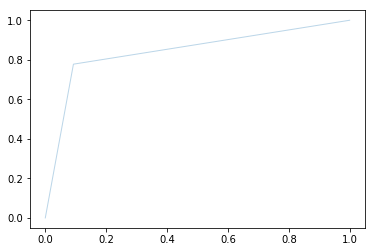

In [14]:
show_ROC(Y_CV, cv_hat)

So this measure is an approximation of the actual measure during training as it appears as it is evaluated per most-recent minibatch in that particular epoch.

## Implementing R@P Optimization

So now to implement the R@P formulae in tensorflow verbatim from the paper for 2 reasons - to see how it does vs traditional accuracy, and to get some experience in implementing custom loss functions in tensorflow.

One note about the below implementation is I decided to divert from the original paper in the base loss function and used Sigmoidal Logistic Crossentropy Loss as opposed to Hinge Loss as the original authors, the reasoning for this is simply that I am considering only a binary classification problem and not a multi-class classification problem that the original authors used.

In [15]:
#Took tensorflow function imports from tensorflow source code
import math

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import function
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import candidate_sampling_ops
from tensorflow.python.ops import embedding_ops
from tensorflow.python.ops import gen_array_ops  # pylint: disable=unused-import
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import variables
from tensorflow.python.util.deprecation import deprecated_args
from tensorflow.python.util.deprecation import deprecated_argument_lookup
from tensorflow.python.util.tf_export import tf_export

#Optimize recall at fixed precision
def r_at_p_loss(target, output, alph_tf = 0.95):
    

    lam_tf = tf.Variable(0.01, tf.float32, name='lam_tf')
    #alph_tf = tf.placeholder(tf.float32, name='alph_tf')
    
    #lam_tf = K.variable(lam_tf, name='lam_tf')
    
    zeros = tf.zeros_like(output)
    ones = tf.ones_like(output)
    
    cond_z = tf.equal(zeros, target)
    cont_one = tf.not_equal(zeros, target)
    
    ind_z = tf.where(cond_z)
    ind_one = tf.where(cont_one)
    
    one_labels = tf.gather_nd(target, ind_one)
    one_logits = tf.gather_nd(output, ind_one)
    
    z_labels = tf.gather_nd(target, ind_z)
    z_logits = tf.gather_nd(output, ind_z)
    
    L_plus = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=one_labels, logits=one_logits))
    L_minus = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=z_labels, logits=z_logits))
    
    Y_plus = tf.reduce_sum(one_labels)
    

    loss_one = tf.multiply(tf.add(1.0, lam_tf), L_plus) 
    loss_two = tf.multiply(tf.multiply(tf.divide(alph_tf, tf.subtract(1.0, alph_tf)), lam_tf), L_minus)
    loss_three = tf.multiply(-1.0, tf.multiply(lam_tf, Y_plus))
    
    fin_loss = tf.add(tf.add(loss_one, loss_two), loss_three)
    
    lam_tf = upd_lambda_rp(lam_tf,  L_plus, L_minus, Y_plus, alph_tf)
    
    return fin_loss

#Define function to optimize lambda by gradient descent (or is it ascent?)
def upd_lambda_rp(lam,  L_plus, L_minus, Y_plus, alph_tf):
    lr = 0.01
    
    #Differential of loss function by lambda
    dl =  tf.subtract(tf.add(L_plus, tf.divide(alph_tf, tf.subtract(1.0, alph_tf))), Y_plus)
    new_lam = tf.add(lam, tf.multiply(lr, dl))
    
    return new_lam



In [16]:
test_model = NN_model_v2((X_Train.shape[1], ), layers, regularizers.l2(0.01), None)
test_model.compile(optimizer = "Adam", loss = r_at_p_loss, metrics = ["accuracy", K_F1_score])
test_model.fit(x = X_Train, y = Y_Train, epochs = 256, verbose = 1)

Epoch 1/256
691/691 [==============================] - 1s 753us/step - loss: 9.6174 - acc: 0.3980 - K_F1_score: 0.5033
Epoch 2/256
691/691 [==============================] - 0s 304us/step - loss: 9.2905 - acc: 0.3777 - K_F1_score: 0.5475
Epoch 3/256
691/691 [==============================] - 0s 289us/step - loss: 9.1652 - acc: 0.3777 - K_F1_score: 0.5473
Epoch 4/256
691/691 [==============================] - 0s 289us/step - loss: 9.0826 - acc: 0.3777 - K_F1_score: 0.5479
Epoch 5/256
691/691 [==============================] - 0s 304us/step - loss: 9.0085 - acc: 0.3777 - K_F1_score: 0.5511
Epoch 6/256
691/691 [==============================] - 0s 318us/step - loss: 8.9302 - acc: 0.3777 - K_F1_score: 0.5575
Epoch 7/256
691/691 [==============================] - 0s 289us/step - loss: 8.8343 - acc: 0.3777 - K_F1_score: 0.5699
Epoch 8/256
691/691 [==============================] - 0s 304us/step - loss: 8.7524 - acc: 0.3777 - K_F1_score: 0.5816
Epoch 9/256
691/691 [===========================

691/691 [==============================] - 0s 318us/step - loss: 7.8549 - acc: 0.8220 - K_F1_score: 0.7065
Epoch 70/256
691/691 [==============================] - 0s 318us/step - loss: 7.8535 - acc: 0.8408 - K_F1_score: 0.7149
Epoch 71/256
691/691 [==============================] - 0s 362us/step - loss: 7.8135 - acc: 0.8365 - K_F1_score: 0.7091
Epoch 72/256
691/691 [==============================] - 0s 333us/step - loss: 7.7869 - acc: 0.8437 - K_F1_score: 0.7115
Epoch 73/256
691/691 [==============================] - 0s 376us/step - loss: 7.8131 - acc: 0.8321 - K_F1_score: 0.7056
Epoch 74/256
691/691 [==============================] - 0s 347us/step - loss: 7.7996 - acc: 0.8394 - K_F1_score: 0.7162
Epoch 75/256
691/691 [==============================] - 0s 304us/step - loss: 7.7621 - acc: 0.8423 - K_F1_score: 0.7196
Epoch 76/256
691/691 [==============================] - 0s 289us/step - loss: 7.7704 - acc: 0.8437 - K_F1_score: 0.7162
Epoch 77/256
691/691 [==============================]

691/691 [==============================] - 0s 304us/step - loss: 7.6360 - acc: 0.8480 - K_F1_score: 0.7511
Epoch 138/256
691/691 [==============================] - 0s 304us/step - loss: 7.6233 - acc: 0.8480 - K_F1_score: 0.7482
Epoch 139/256
691/691 [==============================] - 0s 304us/step - loss: 7.6290 - acc: 0.8480 - K_F1_score: 0.7446
Epoch 140/256
691/691 [==============================] - 0s 318us/step - loss: 7.6284 - acc: 0.8466 - K_F1_score: 0.7415
Epoch 141/256
691/691 [==============================] - 0s 318us/step - loss: 7.6334 - acc: 0.8466 - K_F1_score: 0.7501
Epoch 142/256
691/691 [==============================] - 0s 289us/step - loss: 7.6232 - acc: 0.8480 - K_F1_score: 0.7497
Epoch 143/256
691/691 [==============================] - 0s 347us/step - loss: 7.6166 - acc: 0.8480 - K_F1_score: 0.7547
Epoch 144/256
691/691 [==============================] - 0s 391us/step - loss: 7.6009 - acc: 0.8480 - K_F1_score: 0.7494
Epoch 145/256
691/691 [=======================

691/691 [==============================] - 0s 304us/step - loss: 7.5526 - acc: 0.8480 - K_F1_score: 0.7695
Epoch 205/256
691/691 [==============================] - 0s 289us/step - loss: 7.5206 - acc: 0.8480 - K_F1_score: 0.7613
Epoch 206/256
691/691 [==============================] - 0s 304us/step - loss: 7.5268 - acc: 0.8480 - K_F1_score: 0.7628
Epoch 207/256
691/691 [==============================] - 0s 318us/step - loss: 7.5422 - acc: 0.8480 - K_F1_score: 0.7648
Epoch 208/256
691/691 [==============================] - 0s 289us/step - loss: 7.5444 - acc: 0.8480 - K_F1_score: 0.7669
Epoch 209/256
691/691 [==============================] - 0s 304us/step - loss: 7.5311 - acc: 0.8480 - K_F1_score: 0.7710
Epoch 210/256
691/691 [==============================] - 0s 304us/step - loss: 7.5322 - acc: 0.8480 - K_F1_score: 0.7654
Epoch 211/256
691/691 [==============================] - 0s 304us/step - loss: 7.5128 - acc: 0.8466 - K_F1_score: 0.7693
Epoch 212/256
691/691 [=======================

In [17]:
train_pred = test_model.predict(x = X_Train)
cv_pred = test_model.predict(x = X_CV)

train_hat = normalize_predictions(train_pred)
cv_hat = normalize_predictions(cv_pred)

show_acc(Y_Train, train_hat)
show_acc(Y_CV, cv_hat)

Accuracy =  84.5151953690304
F1 Score =  0.8043875685557588

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        220.0          66.0
1  Pred False         41.0         364.0
Accuracy =  85.5
F1 Score =  0.8323699421965318

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         72.0          20.0
1  Pred False          9.0          99.0


ROC Score :  0.8604108309990661


0.8604108309990661

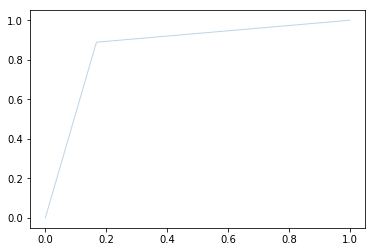

In [18]:
show_ROC(Y_CV, cv_hat)

So training R@P95 appears to have lower accuracy when optimizing, but generalizes to the data better and suffers from less overfitting, while also improving the ROC score.  Obviously this is very subject to convergence at local minima as a result of random initialization,  so should be taken somewhat lightly as a result.  However it is encouraging nonetheless.

This indicates that there's solid diversity within the trained weights between the two systems, so when using ensembles of neural networks having systems trained with multiple objectives will likely be a very valuable ensembling technique.

### Optimizing over PR Curve

So the next logical step is to iterate this method over K steps to effectively maximize the area under the PR curve, this is done by iterating over multiple values of R@P and integrating via Simpson's Rule.

In [19]:
lams = {}

#To optimize aucpr simply integrate over r@p across a range using simpson's rule integration
def aucpr_loss(target, output, k = 5):
    
    zeros = tf.zeros_like(output)
    ones = tf.ones_like(output)
    
    #Define all Lplus and Lminus matrices
    cond_z = tf.equal(zeros, target)
    cont_one = tf.not_equal(zeros, target)
    
    ind_z = tf.where(cond_z)
    ind_one = tf.where(cont_one)
    
    one_labels = tf.gather_nd(target, ind_one)
    one_logits = tf.gather_nd(output, ind_one)
    
    z_labels = tf.gather_nd(target, ind_z)
    z_logits = tf.gather_nd(output, ind_z)
    
    #Calculate basic loss functions
    L_plus = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=one_labels, logits=one_logits))
    L_minus = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=z_labels, logits=z_logits))
        
    Y_plus = tf.reduce_sum(one_labels)
    
    #dynamic assign of lambda variables
    for j in range(k):
        lams['lam_tf'+str(k)] =  tf.Variable(0.01, tf.float32, name='lam_tf'+str(k))
    
    
    fin_loss = 0.0
    
    #Simpson's rule integrate
    for i in range(k):
        if i == 0 :
            alph_t1 = float(0.5)
        else :
            alph_t1 = float(0.5 + ((1 - 0.5)*(i))/k)
        
        alph_t = float(0.5 + ((0.95 - 0.5)*(i + 1)/k))
        #alph_t = 0.95
    
        #Calculate p@r losses
        loss_one_t = tf.multiply(tf.add(1.0, lams['lam_tf'+str(k)]), L_plus) 
        loss_two_t = tf.multiply(tf.multiply(tf.divide(alph_t, tf.subtract(1.0, alph_t)), lams['lam_tf'+str(k)]), L_minus)
        loss_three_t = tf.multiply(-1.0, tf.multiply(lams['lam_tf'+str(k)], Y_plus))
        
        #Calculate t losses (note had to add absoloute function here to increase convergence)
        fin_loss_t = tf.abs(tf.add(tf.add(loss_one_t, loss_two_t), loss_three_t))
        
        #Update lambda_k
        lams['lam_tf'+str(k)] = upd_lambda_rp(lams['lam_tf'+str(k)],  L_plus, L_minus, Y_plus, alph_t)
        
        #Update and sum
        if i == 0:
            loss_in = fin_loss_t*alph_t
            #loss_in = 0.0
        else :
            loss_in = (alph_t - alph_t1)*fin_loss_t
            #loss_in = abs(fin_loss_t)
        
        fin_loss += loss_in
    
    return fin_loss

In [20]:
lams = {}
#regularizers.l2(0.01)
test_model = NN_model_v2((X_Train.shape[1], ), layers, None, None)
test_model.compile(optimizer = "sgd", loss = aucpr_loss, metrics = ["accuracy", K_F1_score])
test_model.fit(x = X_Train, y = Y_Train, epochs = 256, verbose = 1)

Epoch 1/256
691/691 [==============================] - 0s 666us/step - loss: 5.7919 - acc: 0.6107 - K_F1_score: 0.3466
Epoch 2/256
691/691 [==============================] - 0s 275us/step - loss: 5.9658 - acc: 0.6223 - K_F1_score: 0.3334
Epoch 3/256
691/691 [==============================] - 0s 275us/step - loss: 5.6718 - acc: 0.6223 - K_F1_score: 0.3219
Epoch 4/256
691/691 [==============================] - 0s 275us/step - loss: 5.6691 - acc: 0.6223 - K_F1_score: 0.3138
Epoch 5/256
691/691 [==============================] - 0s 232us/step - loss: 5.7342 - acc: 0.6223 - K_F1_score: 0.3019
Epoch 6/256
691/691 [==============================] - 0s 260us/step - loss: 5.7300 - acc: 0.6223 - K_F1_score: 0.2909
Epoch 7/256
691/691 [==============================] - 0s 246us/step - loss: 5.6553 - acc: 0.6223 - K_F1_score: 0.2870
Epoch 8/256
691/691 [==============================] - 0s 289us/step - loss: 5.5877 - acc: 0.6223 - K_F1_score: 0.2784
Epoch 9/256
691/691 [===========================

691/691 [==============================] - 0s 289us/step - loss: 5.4124 - acc: 0.7931 - K_F1_score: 0.5454
Epoch 70/256
691/691 [==============================] - 0s 246us/step - loss: 5.4921 - acc: 0.7873 - K_F1_score: 0.5369
Epoch 71/256
691/691 [==============================] - 0s 246us/step - loss: 5.4942 - acc: 0.7699 - K_F1_score: 0.5098
Epoch 72/256
691/691 [==============================] - 0s 246us/step - loss: 5.4783 - acc: 0.7511 - K_F1_score: 0.4945
Epoch 73/256
691/691 [==============================] - 0s 246us/step - loss: 5.4039 - acc: 0.7467 - K_F1_score: 0.4841
Epoch 74/256
691/691 [==============================] - 0s 260us/step - loss: 5.4064 - acc: 0.7771 - K_F1_score: 0.5408
Epoch 75/256
691/691 [==============================] - 0s 232us/step - loss: 5.3716 - acc: 0.7786 - K_F1_score: 0.5464
Epoch 76/256
691/691 [==============================] - 0s 275us/step - loss: 5.3219 - acc: 0.7945 - K_F1_score: 0.5744
Epoch 77/256
691/691 [==============================]

691/691 [==============================] - 0s 275us/step - loss: 5.3422 - acc: 0.8104 - K_F1_score: 0.6590
Epoch 138/256
691/691 [==============================] - 0s 260us/step - loss: 5.3511 - acc: 0.8119 - K_F1_score: 0.6628
Epoch 139/256
691/691 [==============================] - 0s 260us/step - loss: 5.3574 - acc: 0.7959 - K_F1_score: 0.6453
Epoch 140/256
691/691 [==============================] - 0s 246us/step - loss: 5.4670 - acc: 0.8234 - K_F1_score: 0.7133
Epoch 141/256
691/691 [==============================] - 0s 246us/step - loss: 5.3673 - acc: 0.7988 - K_F1_score: 0.6479
Epoch 142/256
691/691 [==============================] - 0s 260us/step - loss: 5.2825 - acc: 0.7974 - K_F1_score: 0.6455
Epoch 143/256
691/691 [==============================] - 0s 246us/step - loss: 5.2600 - acc: 0.8090 - K_F1_score: 0.6584
Epoch 144/256
691/691 [==============================] - 0s 275us/step - loss: 5.4050 - acc: 0.8191 - K_F1_score: 0.6879
Epoch 145/256
691/691 [=======================

691/691 [==============================] - 0s 333us/step - loss: 5.2814 - acc: 0.8292 - K_F1_score: 0.7089
Epoch 205/256
691/691 [==============================] - 0s 304us/step - loss: 5.2649 - acc: 0.8205 - K_F1_score: 0.6953
Epoch 206/256
691/691 [==============================] - 0s 275us/step - loss: 5.3486 - acc: 0.8162 - K_F1_score: 0.6886
Epoch 207/256
691/691 [==============================] - 0s 275us/step - loss: 5.2816 - acc: 0.8263 - K_F1_score: 0.6948
Epoch 208/256
691/691 [==============================] - 0s 246us/step - loss: 5.3443 - acc: 0.8307 - K_F1_score: 0.7071
Epoch 209/256
691/691 [==============================] - 0s 260us/step - loss: 5.2293 - acc: 0.8307 - K_F1_score: 0.7101
Epoch 210/256
691/691 [==============================] - 0s 289us/step - loss: 5.2683 - acc: 0.8292 - K_F1_score: 0.7228
Epoch 211/256
691/691 [==============================] - 0s 260us/step - loss: 5.2835 - acc: 0.8278 - K_F1_score: 0.7060
Epoch 212/256
691/691 [=======================

In [21]:
train_pred = test_model.predict(x = X_Train)
cv_pred = test_model.predict(x = X_CV)

train_hat = normalize_predictions(train_pred)
cv_hat = normalize_predictions(cv_pred)

show_acc(Y_Train, train_hat)
show_acc(Y_CV, cv_hat)

Accuracy =  83.06801736613603
F1 Score =  0.7334851936218678

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        161.0          17.0
1  Pred False        100.0         413.0
Accuracy =  89.5
F1 Score =  0.864516129032258

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         67.0           7.0
1  Pred False         14.0         112.0


ROC Score :  0.884168482207698


0.884168482207698

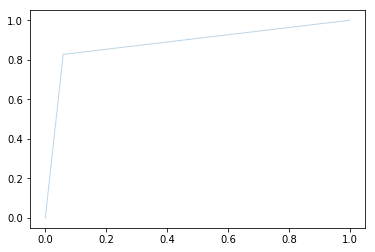

In [22]:
show_ROC(Y_CV, cv_hat)

So implementing a pseudo integral over multiple values seems to have yielded a somehwat interesting result with a poor training accuracy/F1 score but excelled cross validation results, however this is definitely a fluke.  Across multiple iterations it was somewhat inconsistent with convergence and yielded middling results.

However, this is likely to be a useful metric to incorporate into future ensembles so worth keeping around.


Overall the experiment into using non-differentiable objectives seems to have given encouraging results. The next step is therefore to implement AUCROC or other metrics, or potentially use genetic programming to develop entirely new metrics, or implement algorithms from Optimizing Non-decomposable Measures with Deep Networks, such as DUPLE which looked like a solid algorithm.  There's many more directions opened up by this relatively unexplored territory.

Below is also an implementation of the P@R algorithm, however this seemed to not converge, whether through incorrect implementation or poor algorithm I don't know.

In [ ]:
#Function for optimizing precision at fixed recall
def p_at_r_loss(target, output, beta_tf = 0.7):

    lam_tf = tf.Variable(0.01, tf.float32, name='lam_tf')
    #alph_tf = tf.placeholder(tf.float32, name='alph_tf')
    
    #lam_tf = K.variable(lam_tf, name='lam_tf')
    
    zeros = tf.zeros_like(output)
    ones = tf.ones_like(output)
    
    cond_z = tf.equal(zeros, target)
    cont_one = tf.not_equal(zeros, target)
    
    ind_z = tf.where(cond_z)
    ind_one = tf.where(cont_one)
    
    one_labels = tf.gather_nd(target, ind_one)
    one_logits = tf.gather_nd(output, ind_one)
    
    z_labels = tf.gather_nd(target, ind_z)
    z_logits = tf.gather_nd(output, ind_z)
    
    L_plus = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=one_labels, logits=one_logits))
    L_minus = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=z_labels, logits=z_logits))
    
    Y_plus = tf.reduce_sum(one_labels)
    

    loss_one = tf.add(tf.add(tf.divide(L_plus, Y_plus), beta_tf), -1.0)
                      
    fin_loss = tf.add(tf.multiply(lam_tf, loss_one), L_minus)
    
    lam_tf = upd_lambda_pr(lam_tf,  L_plus, L_minus, Y_plus, beta_tf)
    
    return fin_loss

#Define function to optimize lambda by gradient descent (or is it ascent?)
def upd_lambda_pr(lam,  L_plus, L_minus, Y_plus, beta_tf):
    lr = 0.01
    
    #Differential of loss by lambda
    dl =  tf.add(tf.add(tf.divide(L_plus, Y_plus), beta_tf), -1.0)
    new_lam = tf.add(lam, tf.multiply(lr, dl))
    
    return new_lam